let us start by importing the required functions

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# import statsemodels.api as sm
import SALib
import seaborn as sns
import mpl_toolkits.axisartist as AA
import mpld3
import scipy as sp
import copy
import matplotlib.ticker as ticker

from ema_workbench import (Model, RealParameter, IntegerParameter, Policy, CategoricalParameter, Constant, TimeSeriesOutcome, ScalarOutcome, perform_experiments, ema_logging, save_results, load_results)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator
from ema_workbench.connectors.pysd_connector import PysdModel 
from ema_workbench.connectors import vensimDLLwrapper
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import load_results
from ema_workbench.util import ema_logging

from ema_workbench.analysis import prim
from ema_workbench.analysis.plotting import lines, multiple_densities, kde_over_time
from ema_workbench.analysis.plotting_util import KDE
from ema_workbench.analysis.plotting_util import determine_time_dimension
from ema_workbench.analysis.pairs_plotting import pairs_scatter

from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from SALib.test_functions import Ishigami

from mpl_toolkits.axes_grid1 import host_subplot

from scipy.stats import linregress

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\guri_\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)


<Logger EMA (DEBUG)>

# With Relocation using existing Housing

In [3]:
vensimModel1 = VensimModel("Step2Model", model_file="BaseCase_new_withReconversionFinal_Step2.vpm" )

In [4]:
vensimModel1.uncertainties = [

            RealParameter("Average Fertility Rate", 0.01, 0.025),
            RealParameter("Average Mortality Rate", 0.00126, 0.00154),
            IntegerParameter("BASE Average Household size", 2, 7),
#             RealParameter("Fraction of people selling houses when leaving city", 0.1, 0.4),     
            RealParameter("average Immigration percent", 0.01, 0.06),
            RealParameter("Housing Area Per person", 0.000004, 0.000006),
            RealParameter("Floor Area Ratio", 2, 7),
            RealParameter("Average Residential approval period", 0.5, 2),
            RealParameter("Base Green Area commisioned per year", 0.02, 0.06),
            RealParameter("average green area construction period", 0.5, 2),
            RealParameter("Base Economic area Conversion rate", 0.01, 0.06),
            RealParameter("Base Slum reconversion rate", 0.01, 0.06),
            RealParameter("Fraction of people selling houses when leaving city", 0.1, 0.5),
            RealParameter("house construction time", 0.5, 2),
            IntegerParameter("time delay effect uncertainty of spending capacity on housing price", 1, 4),
            RealParameter("Slum dwelling area per person", 0.000004, 0.000006),
            RealParameter("Base residential conversion rate", 0.01, 0.05),
            RealParameter("average Emmigration percent", 0.008, 0.05),
            RealParameter("Relocation Rate", 0.001, 0.02), #for relocation of population on streets
            RealParameter("Average Commercial Approval Period", 0.5, 2),
#             RealParameter("Economic area deconversion Period", 0.5, 1.5),
            RealParameter("Average Slum Construction period", 0.1, 0.5),
            RealParameter("Average slum Demolition Period", 0.5, 2),
            RealParameter("uncertainty of average percent of inflation effect", 0.01, 0.08),
            RealParameter("average payment to income ratio for housing", 0.2, 0.5),
#             RealParameter("buy house for investment", 0 ,0.1),
            RealParameter("Ratio of Renting to Buying",0.2, 1),
            RealParameter("margin of empty housing",0.1,0.5)
]

vensimModel1.outcomes = [
    TimeSeriesOutcome('Housing Affordability Rating'),
    TimeSeriesOutcome('People with No Settlements'),
    TimeSeriesOutcome('Illegal Slum Population'),
    TimeSeriesOutcome('Urban Non Residential Area'),
    TimeSeriesOutcome('Urban Residential Land'),
    TimeSeriesOutcome('Slum Area'),
    TimeSeriesOutcome('Green Area')  
]

In [5]:
results1 = perform_experiments(vensimModel1, 1500, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 1500 scenarios * 1 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


In [6]:
results_name = './Step2Model_LHS_1500.tar.gz'
save_results(results1, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Papers\V2\Step2Model_LHS_1500.tar.gz


In [3]:
results1 = load_results('./Step2Model_LHS_1500.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Papers\V2\Step2Model_LHS_1500.tar.gz


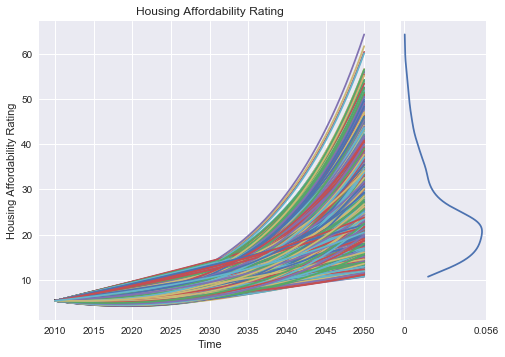

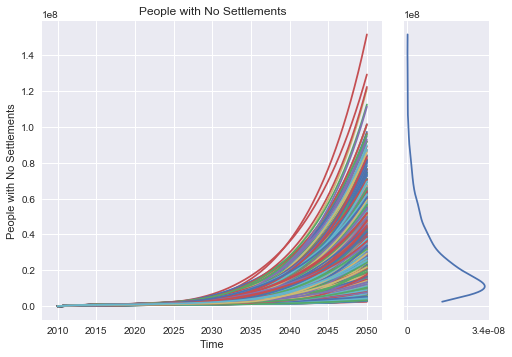

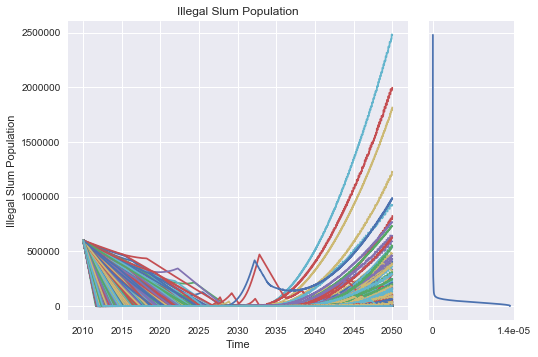

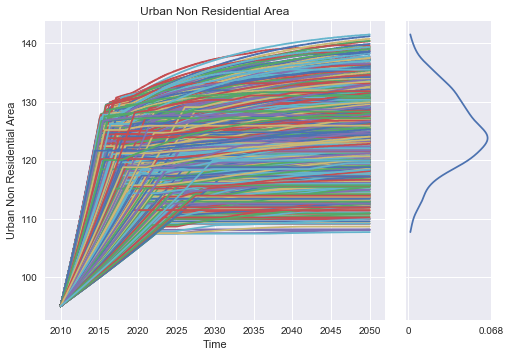

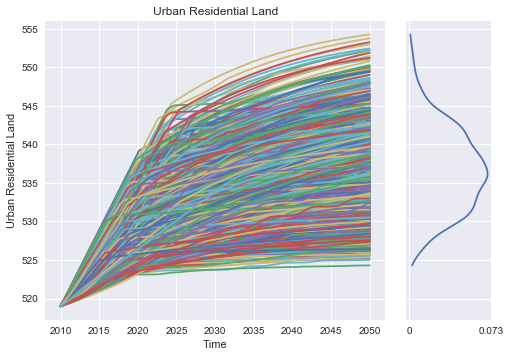

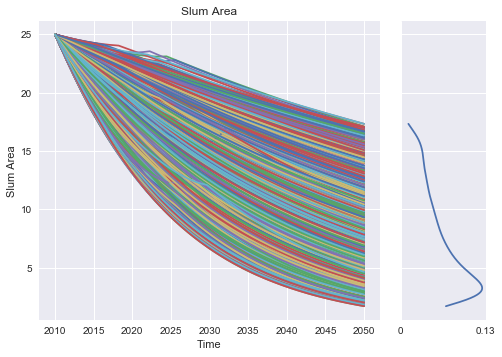

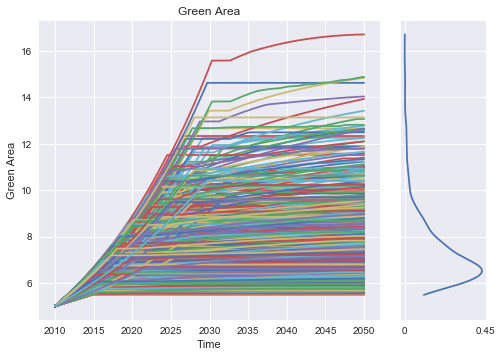

In [7]:
# import matplotlib.pyplot as plt
# from ema_workbench.analysis.plotting import lines 
# from ema_workbench.analysis.plotting_util import KDE

outputs = list(results1[1].keys())[1:] 

for x in outputs:
    fig = lines(results1, outcomes_to_show=[x], density=KDE)
plt.show()

In [4]:
experiments, outcomes = results1

In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Housing Affordability Rating'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>12] = 1
    return classes


prim_obj = prim.setup_prim(results1, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 543 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.18866666666666668, coverage: 0.5211786372007366, density: 1.0 restricted_dimensions: 2


In [11]:
box_1.show_tradeoff()
mpld3.display()

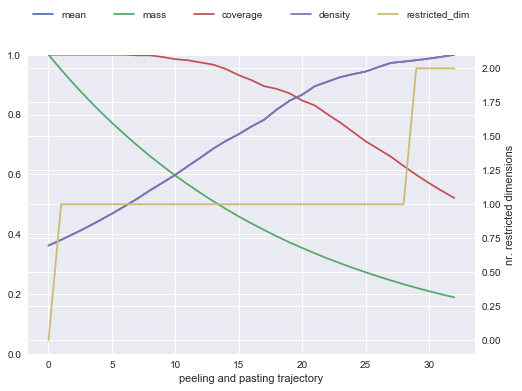

In [12]:
box_1.show_ppt()
plt.show()

coverage    0.598527
density     0.981873
mass        0.220667
mean        0.981873
res dim            2
Name: 29, dtype: object

                                               box 29                         
                                                  min       max      qp values
average payment to income ratio for housing  0.430208  0.499875  7.460180e-132
Average Fertility Rate                       0.010758  0.024995   3.638364e-01



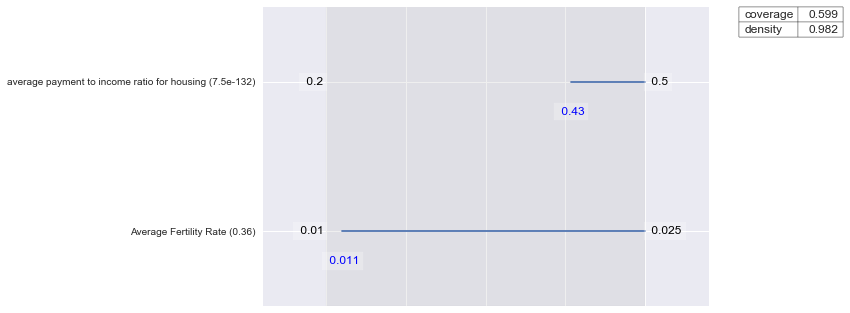

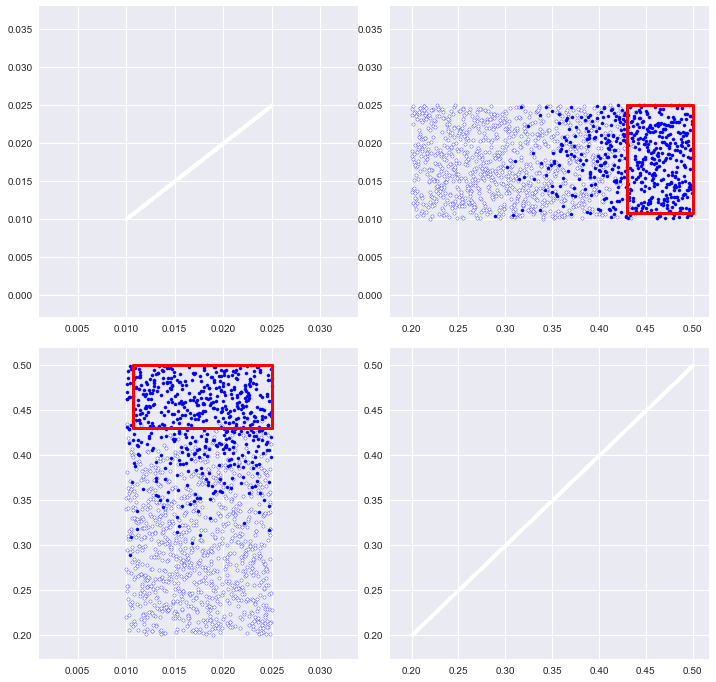

In [14]:
valuebox = 29
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [17]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'People with No Settlements'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>2000000] = 1
    return classes


prim_obj = prim.setup_prim(results1, classifyNoSettle, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1352 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.4266666666666667, coverage: 0.47337278106508873, density: 1.0 restricted_dimensions: 5


In [18]:
box_2.show_tradeoff()
mpld3.display()

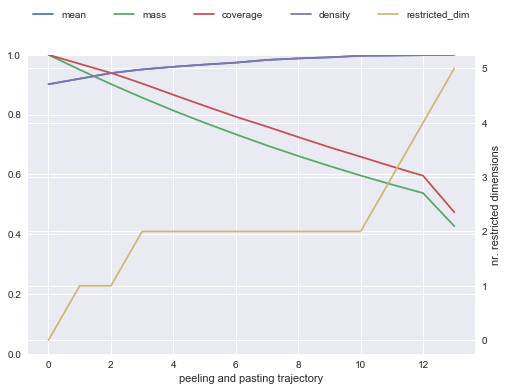

In [19]:
box_2.show_ppt()
plt.show()

coverage    0.473373
density            1
mass        0.426667
mean               1
res dim            5
Name: 13, dtype: object

                                               box 13                        
                                                  min       max     qp values
average Immigration percent                  0.025567  0.059998  9.580525e-19
average payment to income ratio for housing  0.244643  0.499875  1.557497e-04
Base Slum reconversion rate                  0.012707  0.059992  3.860945e-01
BASE Average Household size                  2.000000  5.000000  4.517901e-01
Average Residential approval period          0.500210  1.924228  1.000000e+00



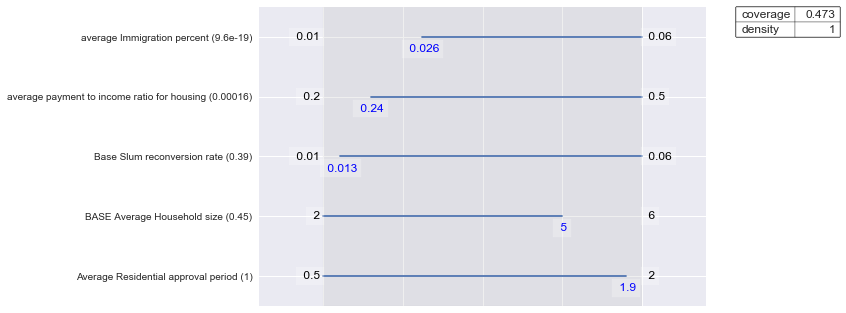

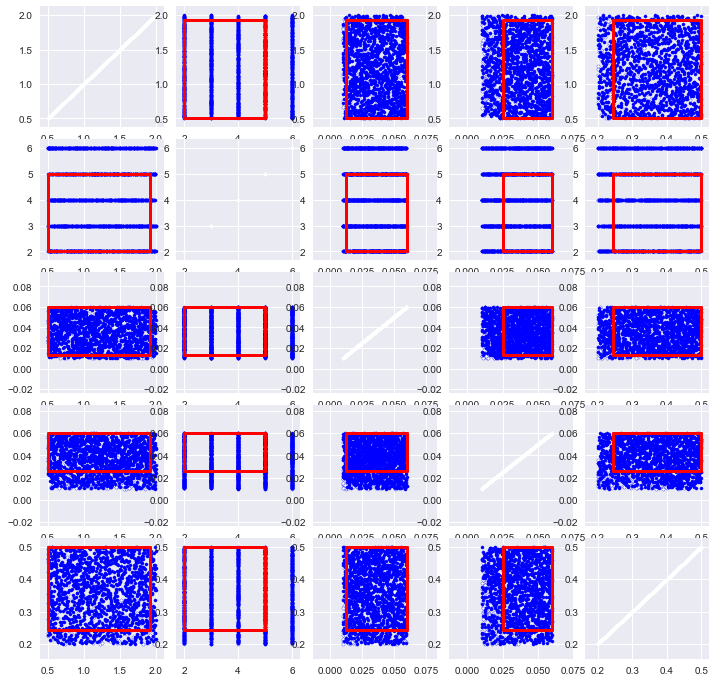

In [20]:
valuebox = 13
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

coverage    0.595414
density     0.998759
mass        0.537333
mean        0.998759
res dim            4
Name: 12, dtype: object

                                               box 12                        
                                                  min       max     qp values
average Immigration percent                  0.025567  0.059998  2.545996e-21
average payment to income ratio for housing  0.244643  0.499875  2.851669e-05
Base Slum reconversion rate                  0.012707  0.059992  4.338159e-01
Average Residential approval period          0.500210  1.924228  4.344522e-01



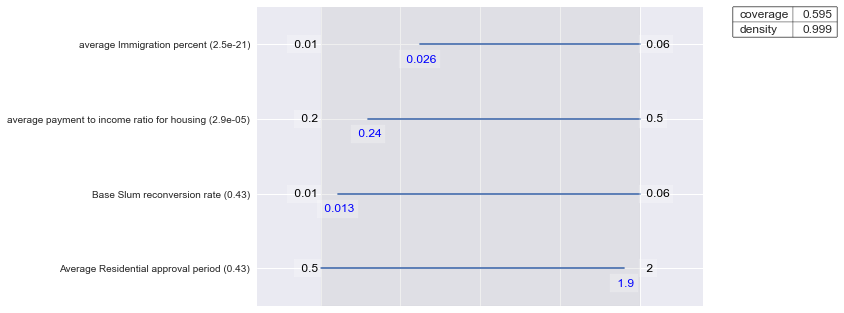

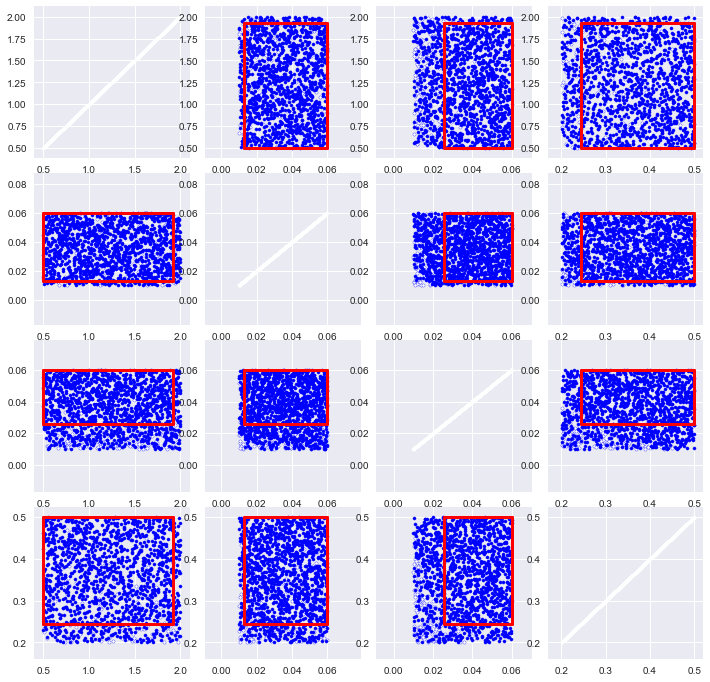

In [21]:
valuebox = 12
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [29]:
def classifyBoth(data):
    ooi_d = 'People with No Settlements'
    result_d = data[ooi_d]
    
    ooi_i = 'Illegal Slum Population'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_d.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_d[:, -1] > 3000000) 
            & (result_i > 300000)] = 1
    
    return classes

combo_prim = prim.setup_prim(results1, classifyBoth,  
                           threshold=0.8, threshold_type=1)
box3 = combo_prim.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1496 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.8133333333333334, coverage: 0.8155080213903744, density: 1.0 restricted_dimensions: 4


In [30]:
box3.show_tradeoff()
mpld3.display()

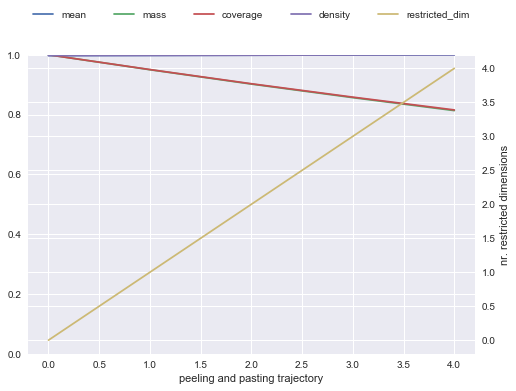

In [31]:
box3.show_ppt()
plt.show()

coverage    0.858289
density     0.999222
mass        0.856667
mean        0.999222
res dim            3
Name: 3, dtype: object

                                box 3                    
                                  min       max qp values
average Emmigration percent  0.009992  0.049992  0.433707
Floor Area Ratio             2.249362  6.998573  0.434505
Relocation Rate              0.001951  0.019998  0.434904



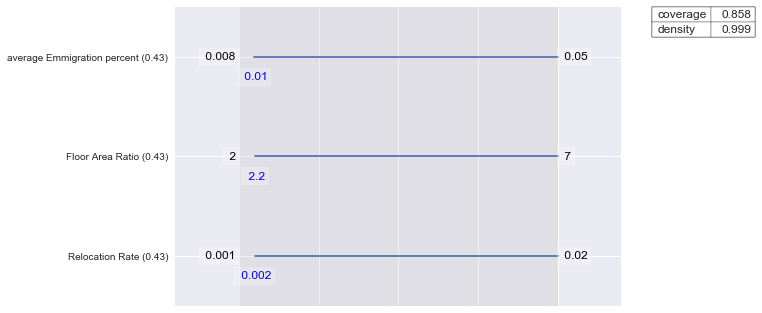

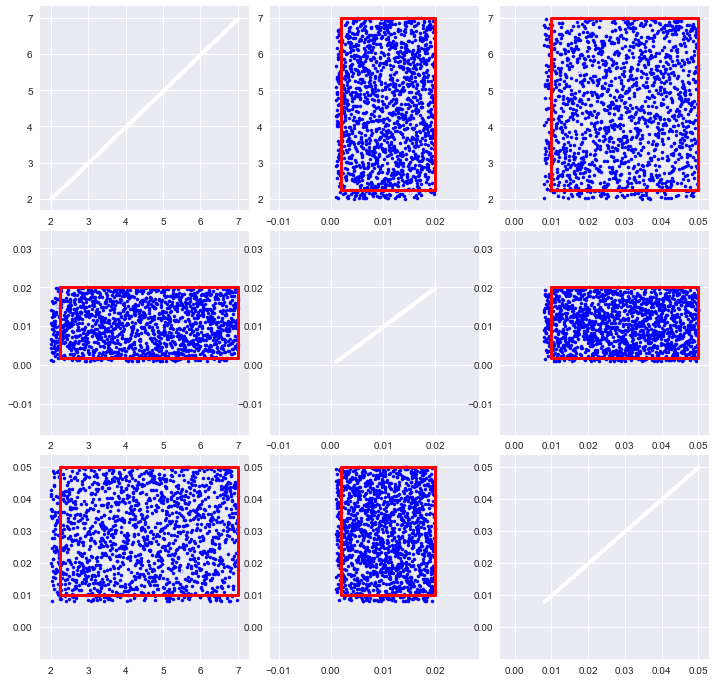

In [32]:
valuebox = 3
box3.inspect(valuebox)
box3.select(valuebox)

top_box = valuebox
box3.inspect(top_box, style='graph')

fig = box3.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [33]:
def classifyUrbanNon(data):
    ooi = 'Urban Non Residential Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<125] = 1
    return classes


prim_obj = prim.setup_prim(results1, classifyUrbanNon, threshold=0.75)
box_4 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1200 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.28733333333333333, coverage: 0.3591666666666667, density: 1.0 restricted_dimensions: 7


In [34]:
box_4.show_tradeoff()
mpld3.display()

coverage    0.675833
density     0.955241
mass           0.566
mean        0.955241
res dim            3
Name: 11, dtype: object

                                       box 11                        
                                          min       max     qp values
Base Economic area Conversion rate   0.010031  0.041404  1.519111e-31
average Immigration percent          0.012740  0.059998  1.095330e-01
Average Residential approval period  0.574865  1.999456  1.705875e-01



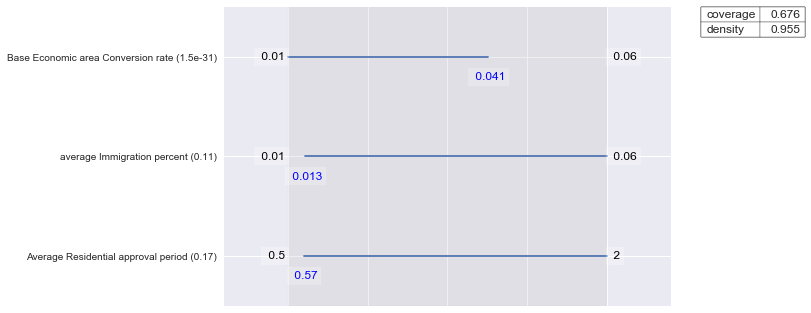

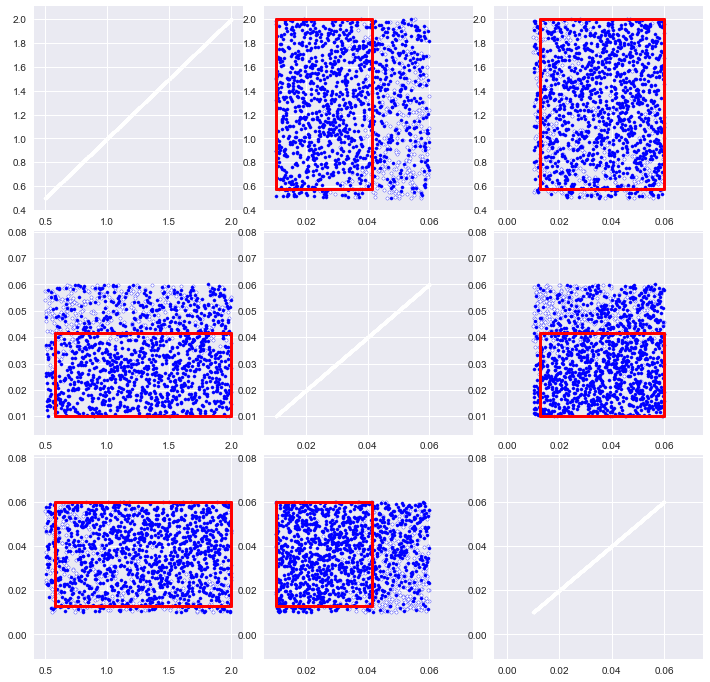

In [35]:
valuebox = 11
box_4.inspect(valuebox)
box_4.select(valuebox)

top_box = valuebox
box_4.inspect(top_box, style='graph')

fig = box_4.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [36]:
def classifyGreenA(data):
    ooi = 'Green Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<7] = 1
    return classes


prim_obj = prim.setup_prim(results1, classifyGreenA, threshold=0.8)
box_5 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 982 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.31866666666666665, coverage: 0.48676171079429736, density: 1.0 restricted_dimensions: 2


In [37]:
box_5.show_tradeoff()
mpld3.display()

coverage    0.922607
density     0.781708
mass        0.772667
mean        0.781708
res dim            2
Name: 5, dtype: object

                                         box 5                        
                                           min       max     qp values
Base Economic area Conversion rate    0.019338  0.059983  3.430911e-16
Base Green Area commisioned per year  0.020010  0.058027  4.264351e-02



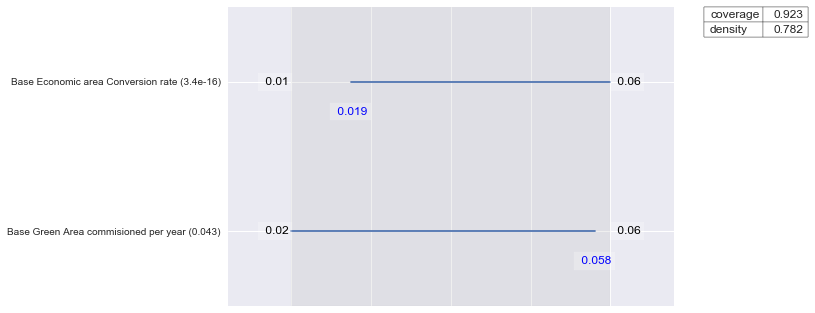

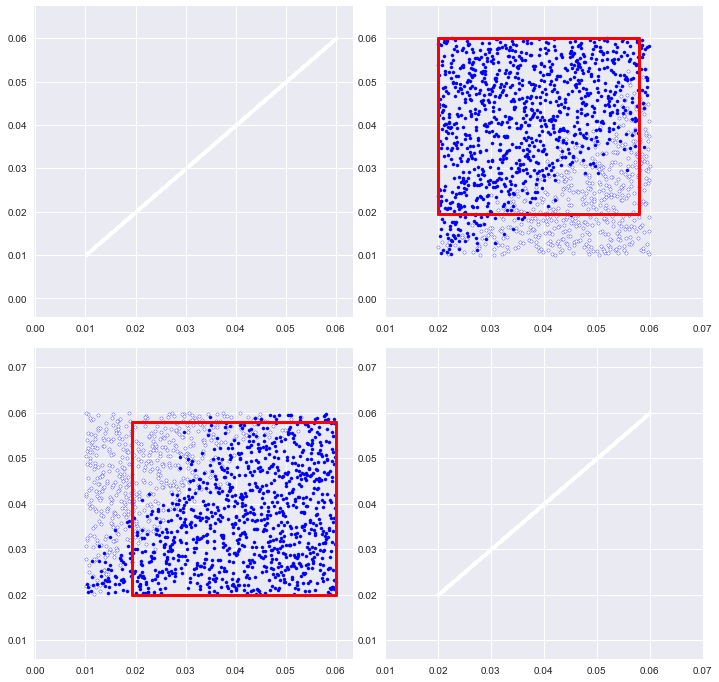

In [38]:
valuebox = 5
box_5.inspect(valuebox)
box_5.select(valuebox)

top_box = valuebox
box_5.inspect(top_box, style='graph')

fig = box_5.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [42]:
def classifySlumA(data):
    ooi = 'Slum Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome >10 ] = 1
    return classes


prim_obj = prim.setup_prim(results1, classifySlumA, threshold=0.8)
box_6 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1321 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.8133333333333334, coverage: 0.9235427706283119, density: 1.0 restricted_dimensions: 1


In [43]:
box_6.show_tradeoff()
mpld3.display()

coverage    0.996215
density     0.923509
mass            0.95
mean        0.923509
res dim            1
Name: 1, dtype: object

                                box 1                        
                                  min       max     qp values
Base Slum reconversion rate  0.010018  0.057509  8.020285e-08



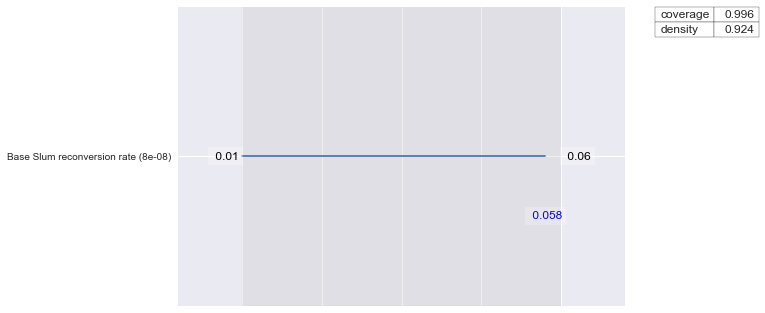

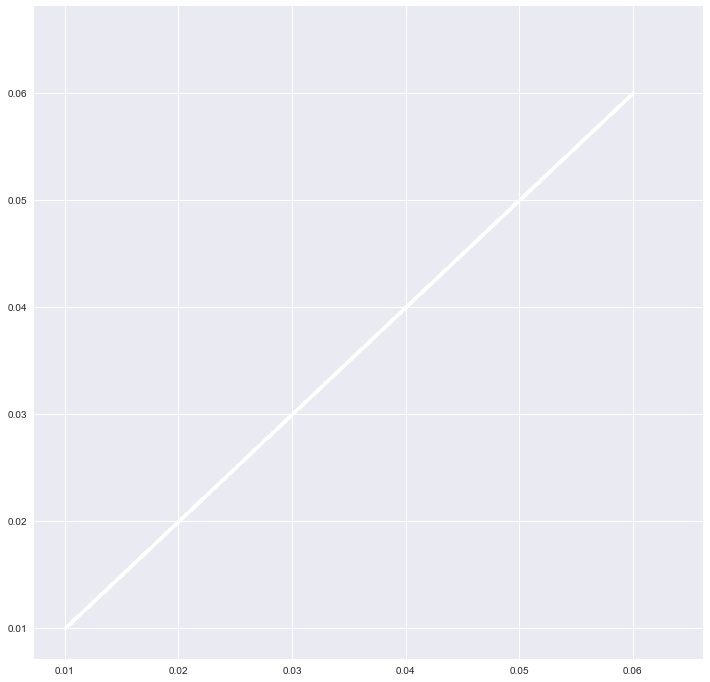

In [44]:
valuebox = 1
box_6.inspect(valuebox)
box_6.select(valuebox)

top_box = valuebox
box_6.inspect(top_box, style='graph')

fig = box_6.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [48]:
def classifySlumPoP(data):
    ooi = 'Illegal Slum Population'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome >20000 ] = 1
    return classes


prim_obj = prim.setup_prim(results1, classifySlumPoP, threshold=0.8)
box_6 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1094 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.51, coverage: 0.6992687385740403, density: 1.0 restricted_dimensions: 2


In [49]:
box_6.show_tradeoff()
mpld3.display()

coverage    0.735832
density     0.998759
mass        0.537333
mean        0.998759
res dim            2
Name: 12, dtype: object

                                 box 12                         
                                    min       max      qp values
Base Slum reconversion rate    0.010018  0.038294  1.961826e-103
Slum dwelling area per person  0.000004  0.000006   1.070385e-01



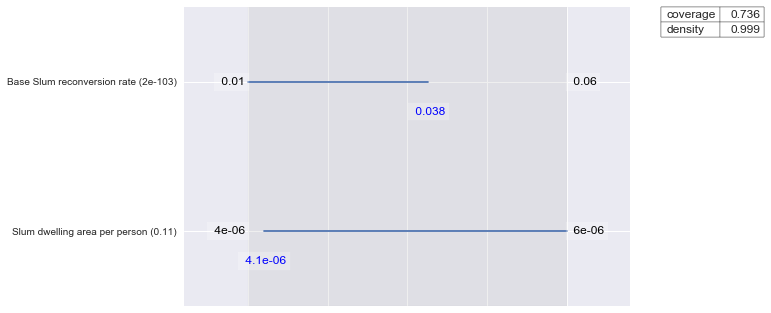

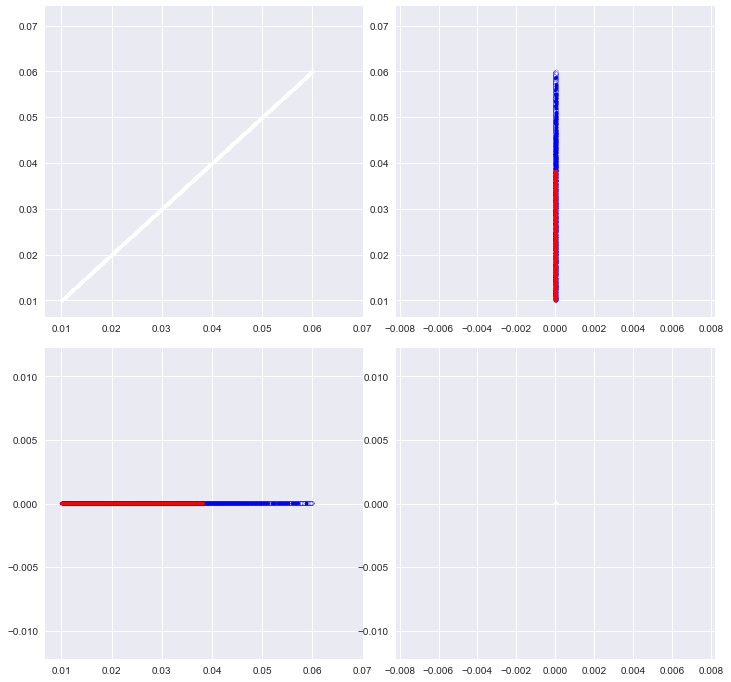

In [50]:
valuebox = 12
box_6.inspect(valuebox)
box_6.select(valuebox)

top_box = valuebox
box_6.inspect(top_box, style='graph')

fig = box_6.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [55]:
def classifyResiA(data):
    ooi = 'Urban Residential Land'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome < 530] = 1
    return classes


prim_obj = prim.setup_prim(results1, classifyResiA, threshold=0.8)
box_5 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 608 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.06666666666666667, coverage: 0.16447368421052633, density: 1.0 restricted_dimensions: 14


In [56]:
box_5.show_tradeoff()
mpld3.display()

coverage    0.620066
density     0.709981
mass           0.354
mean        0.709981
res dim            3
Name: 20, dtype: object

                                       box 20                        
                                          min       max     qp values
Average Residential approval period  0.500210  1.218831  1.478419e-25
Base Economic area Conversion rate   0.021494  0.059983  4.697656e-05
Floor Area Ratio                     2.249362  6.998573  3.396225e-01



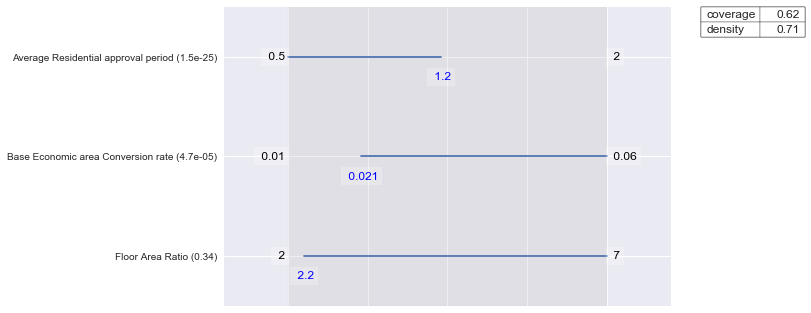

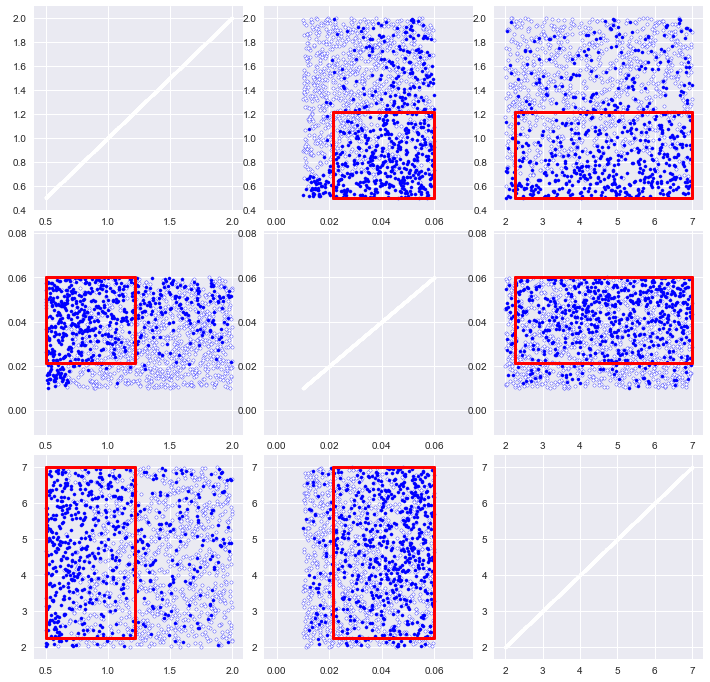

In [57]:
valuebox = 20
box_5.inspect(valuebox)
box_5.select(valuebox)

top_box = valuebox
box_5.inspect(top_box, style='graph')

fig = box_5.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [66]:
def classifyBothAffordResidentialArea(data):
    ooi_d = 'Housing Affordability Rating'
    result_d = data[ooi_d]
    
    ooi_i = 'Urban Residential Land'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_d.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_d[:, -1] > 12) 
            & (result_i <540)] = 1
    
    return classes

combo_prim = prim.setup_prim(results1, classifyBothAffordResidentialArea,  
                           threshold=0.8, threshold_type=1)
box3 = combo_prim.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1053 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.10466666666666667, coverage: 0.14909781576448244, density: 1.0 restricted_dimensions: 12


In [ ]:
# Housing Affordability Rating'),
#     TimeSeriesOutcome('People with No Settlements'),
#     TimeSeriesOutcome('Illegal Slum Population'),
#     TimeSeriesOutcome('Urban Non Residential Area'),
#     TimeSeriesOutcome('Urban Residential Land

In [67]:
box3.show_tradeoff()
mpld3.display()

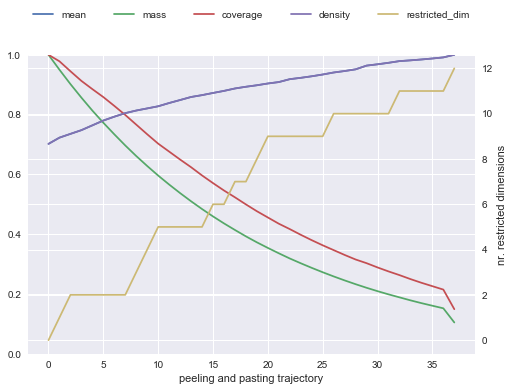

In [68]:
box3.show_ppt()
plt.show()

coverage    0.702754
density      0.82774
mass           0.596
mean         0.82774
res dim            5
Name: 10, dtype: object

                                                      box 10            \
                                                         min       max   
Base Economic area Conversion rate                  0.023286  0.059983   
average payment to income ratio for housing         0.215072  0.499875   
margin of empty housing                             0.118054  0.499853   
Fraction of people selling houses when leaving ...  0.100010  0.480257   
Average Residential approval period                 0.500210  1.915170   

                                                                  
                                                       qp values  
Base Economic area Conversion rate                  3.960799e-11  
average payment to income ratio for housing         1.476010e-01  
margin of empty housing                             2.633151e-01  
Fraction of peop

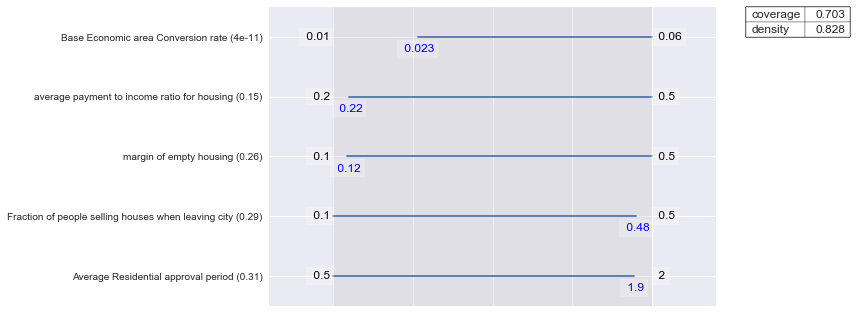

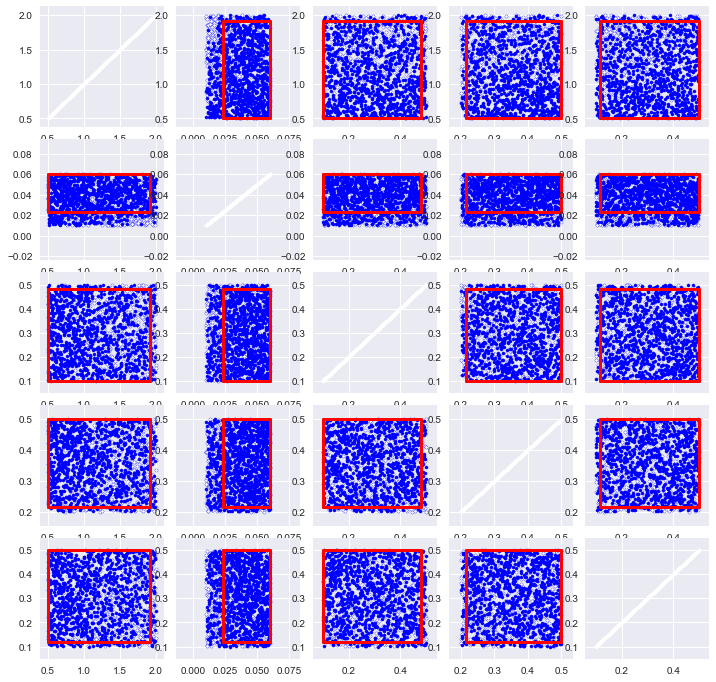

In [69]:
valuebox = 10
box3.inspect(valuebox)
box3.select(valuebox)

top_box = valuebox
box3.inspect(top_box, style='graph')

fig = box3.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [70]:
def classifyBothAffordNonResidentialArea(data):
    ooi_d = 'Housing Affordability Rating'
    result_d = data[ooi_d]
    
    ooi_i = 'Urban Non Residential Area'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_d.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_d[:, -1] > 10) 
            & (result_i <125)] = 1
    
    return classes

combo_prim = prim.setup_prim(results1, classifyBothAffordNonResidentialArea,  
                           threshold=0.8, threshold_type=1)
box3 = combo_prim.find_box()

[MainProcess/INFO] 1500 points remaining, containing 769 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.066, coverage: 0.12873862158647595, density: 1.0 restricted_dimensions: 14


In [63]:
# Housing Affordability Rating'),
#     TimeSeriesOutcome('People with No Settlements'),
#     TimeSeriesOutcome('Illegal Slum Population'),
#     TimeSeriesOutcome('Urban Non Residential Area'),
#     TimeSeriesOutcome('Urban Residential Land

In [71]:
box3.show_tradeoff()
mpld3.display()

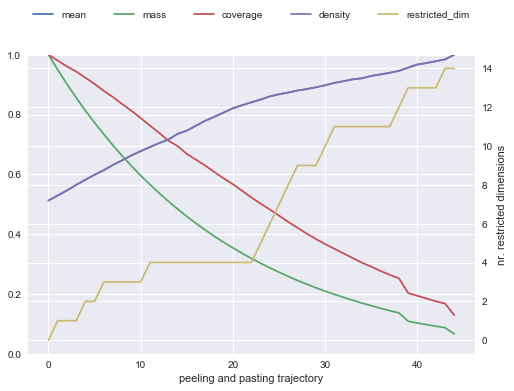

In [72]:
box3.show_ppt()
plt.show()

coverage    0.712614
density      0.71634
mass            0.51
mean         0.71634
res dim            4
Name: 13, dtype: object

                                       box 13                        
                                          min       max     qp values
Average Residential approval period  0.842477  1.999456  8.955319e-07
average Immigration percent          0.018927  0.059998  1.635144e-05
Base Economic area Conversion rate   0.010031  0.052583  1.026785e-03
Base Slum reconversion rate          0.010018  0.057689  1.998827e-01



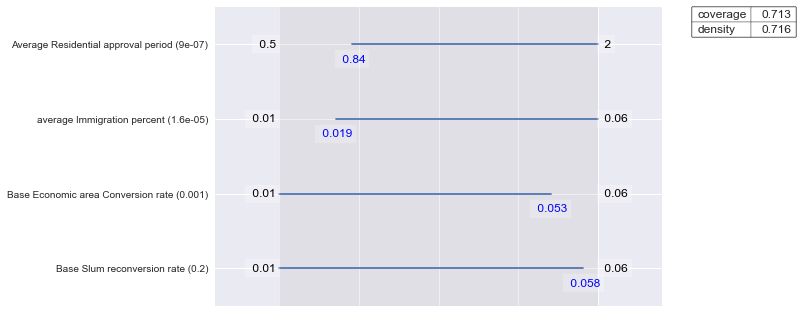

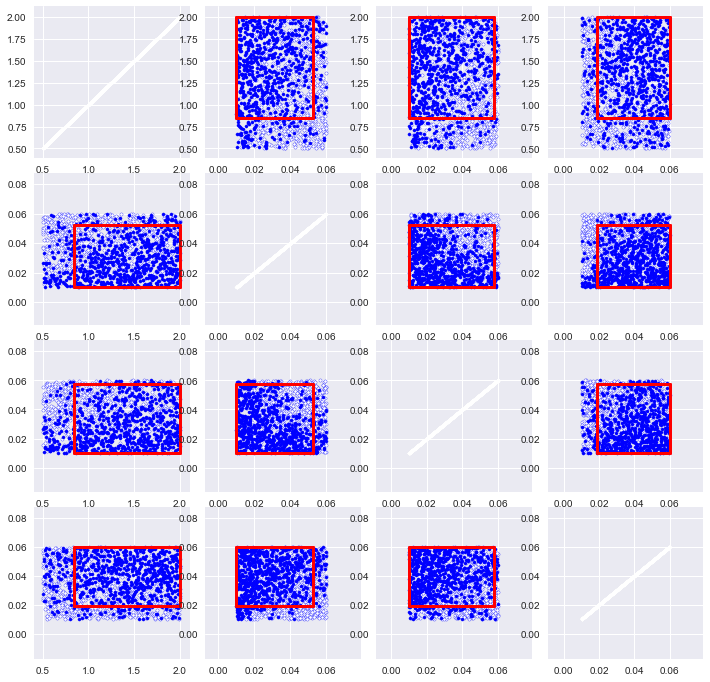

In [73]:
valuebox = 13
box3.inspect(valuebox)
box3.select(valuebox)

top_box = valuebox
box3.inspect(top_box, style='graph')

fig = box3.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [75]:
def classifyBothAffordSettlements(data):
    ooi_d = 'Housing Affordability Rating'
    result_d = data[ooi_d]
    
    ooi_i = 'People with No Settlements'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_d.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_d[:, -1] > 10) 
            & (result_i >5000000)] = 1
    
    return classes

combo_prim = prim.setup_prim(results1, classifyBothAffordSettlements,  
                           threshold=0.8, threshold_type=1)
box3 = combo_prim.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1441 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.6966666666666667, coverage: 0.7251908396946565, density: 1.0 restricted_dimensions: 2


In [ ]:
# Housing Affordability Rating'),
#     TimeSeriesOutcome('People with No Settlements'),
#     TimeSeriesOutcome('Illegal Slum Population'),
#     TimeSeriesOutcome('Urban Non Residential Area'),
#     TimeSeriesOutcome('Urban Residential Land

In [76]:
box3.show_tradeoff()
mpld3.display()

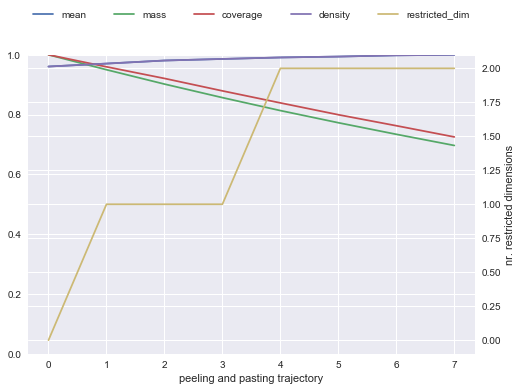

In [77]:
box3.show_ppt()
plt.show()

coverage    0.839001
density     0.990984
mass        0.813333
mean        0.990984
res dim            2
Name: 4, dtype: object

                                                box 4                        
                                                  min       max     qp values
average Immigration percent                  0.017165  0.059998  3.549947e-08
average payment to income ratio for housing  0.215072  0.499875  8.006599e-02



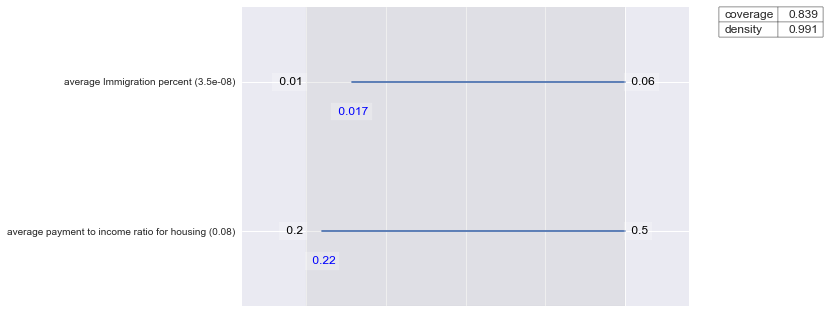

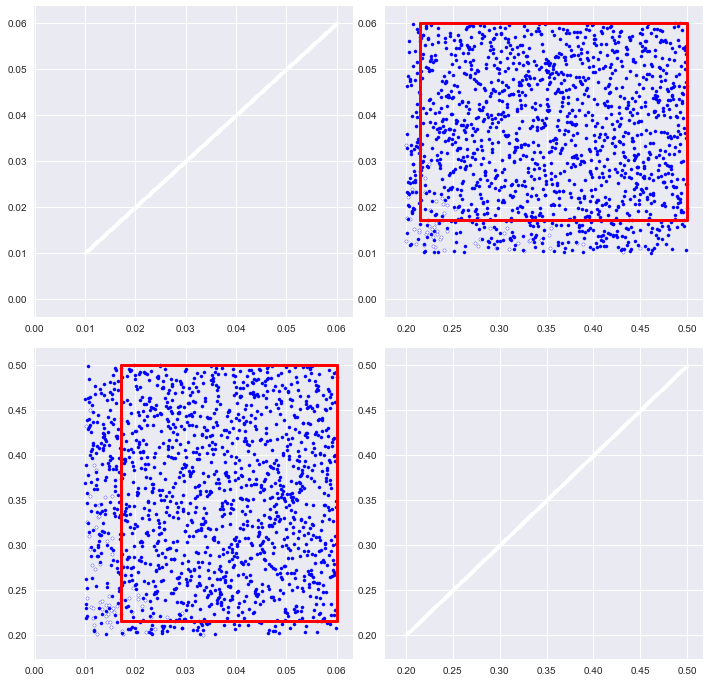

In [79]:
valuebox = 4
box3.inspect(valuebox)
box3.select(valuebox)

top_box = valuebox
box3.inspect(top_box, style='graph')

fig = box3.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()